In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import freq_bands_eeg, low_qual_chans, subject_id_batch_cage_dict

Change plot theme

In [2]:
sns.set_theme()

In [3]:
epoch_folder = select_folder("Select the folder that holds sociability experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

2024-05-08 11:33:40.621 python[14291:572611] +[CATransaction synchronize] called within transaction
2024-05-08 11:33:47.531 python[14291:572611] +[CATransaction synchronize] called within transaction


## Analysis of one subject
Load the epochs of a test subject

In [4]:
subject_id = 39508
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_{subject_id}-epo.fif"), preload=True)

Let's define the channels we wish to investigate

In [5]:
wanted_chans = [chan for chan in epochs.info['ch_names'] if chan not in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [6]:
print(f'There are {len(epochs)} epochs for subject {subject_id}')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "social_cup"])} are social cup interactions epochs')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "non-social_cup"])} are non-social cup interactions epochs')

There are 132 epochs for subject 39508
31 are social cup interactions epochs
101 are non-social cup interactions epochs


The Epoch Array metadata contains further information on how the epochs were created. Let's take a look.

In [8]:
epochs.metadata

,subject_id,genotype,interaction_n,interaction_part_n,interaction_kind,total_interaction_duration,epoch_length
1,39508,DRD2-WT,1,2,non-social_cup,2.768,1.0
2,39508,DRD2-WT,1,3,non-social_cup,2.768,1.0
3,39508,DRD2-WT,2,1,non-social_cup,3.502,1.0
4,39508,DRD2-WT,2,2,non-social_cup,3.502,1.0
11,39508,DRD2-WT,3,5,social_cup,5.069,1.0
...,...,...,...,...,...,...,...
177,39508,DRD2-WT,36,1,non-social_cup,4.968,1.0
178,39508,DRD2-WT,36,2,non-social_cup,4.968,1.0
179,39508,DRD2-WT,36,3,non-social_cup,4.968,1.0
180,39508,DRD2-WT,36,4,non-social_cup,4.968,1.0


The metadata contains the interaction identifier. So all rows where *interaction_n* == 1 is data of one single interaction with in this case the non-social cup (see *interaction_kind* column).

The *interaction_part_n* tells you something about where along the total interaction duration that specific epoch is located.

Let's take the first interaction as an example. We can see, an interaction of 2.768 seconds yielded 3 epochs of 1 seconds (using a 0,116 seconds overlap).

### Define power -> decibel calculation function

In [6]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

### Plot the individual epoch powers

In [14]:
psds_sub_social, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'social_cup'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)
psds_sub_non_social, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'non-social_cup'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)

In [15]:
psds_sub_non_social.shape

(101, 1, 101)

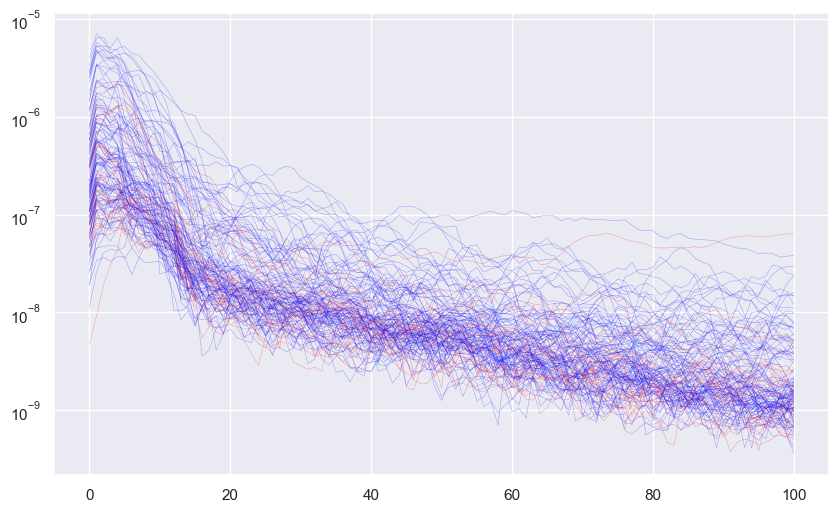

In [18]:
fig = plt.figure(figsize=(10, 6))

for i in range(psds_sub_social.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_social[i, 0, :], alpha=0.4, linewidth=.3, color='red')
    
for i in range(psds_sub_non_social.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_non_social[i, 0, :], alpha=0.4, linewidth=.3, color='blue')
    
plt.yscale('log')
plt.show()

### Power Spectral Density (PSD) calculation for the one subject

In [19]:
df = pd.DataFrame()

for interaction_type in epochs.metadata.interaction_kind.unique():
    
    subject_data = epochs[epochs.metadata["interaction_kind"] == interaction_type]
    subject_id = subject_data.metadata["subject_id"].iloc[0]
    genotype = subject_data.metadata["genotype"].iloc[0]
    
    for channel in wanted_chans:
        # skip plotting data of bad quality
        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            subject_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_data.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]
        
        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
        
        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
            "interaction_kind": interaction_type,
        })])

Let's inspect it a bit

In [20]:
df.head()

,freq,psd (means),psd (norm),subject_id,genotype,channel,interaction_kind
0,0.0,5.022143e-07,0.053185,39508,DRD2-WT,OFC_R,non-social_cup
1,1.0,9.925520e-07,0.104053,39508,DRD2-WT,OFC_R,non-social_cup
2,2.0,9.155035e-07,0.097085,39508,DRD2-WT,OFC_R,non-social_cup
3,3.0,8.093500e-07,0.085262,39508,DRD2-WT,OFC_R,non-social_cup
4,4.0,8.106398e-07,0.085860,39508,DRD2-WT,OFC_R,non-social_cup


And now we plot the non-social-cup vs social-cup powers for all channels. As we're only looking at one subject, we cannot yet compare genotype differences

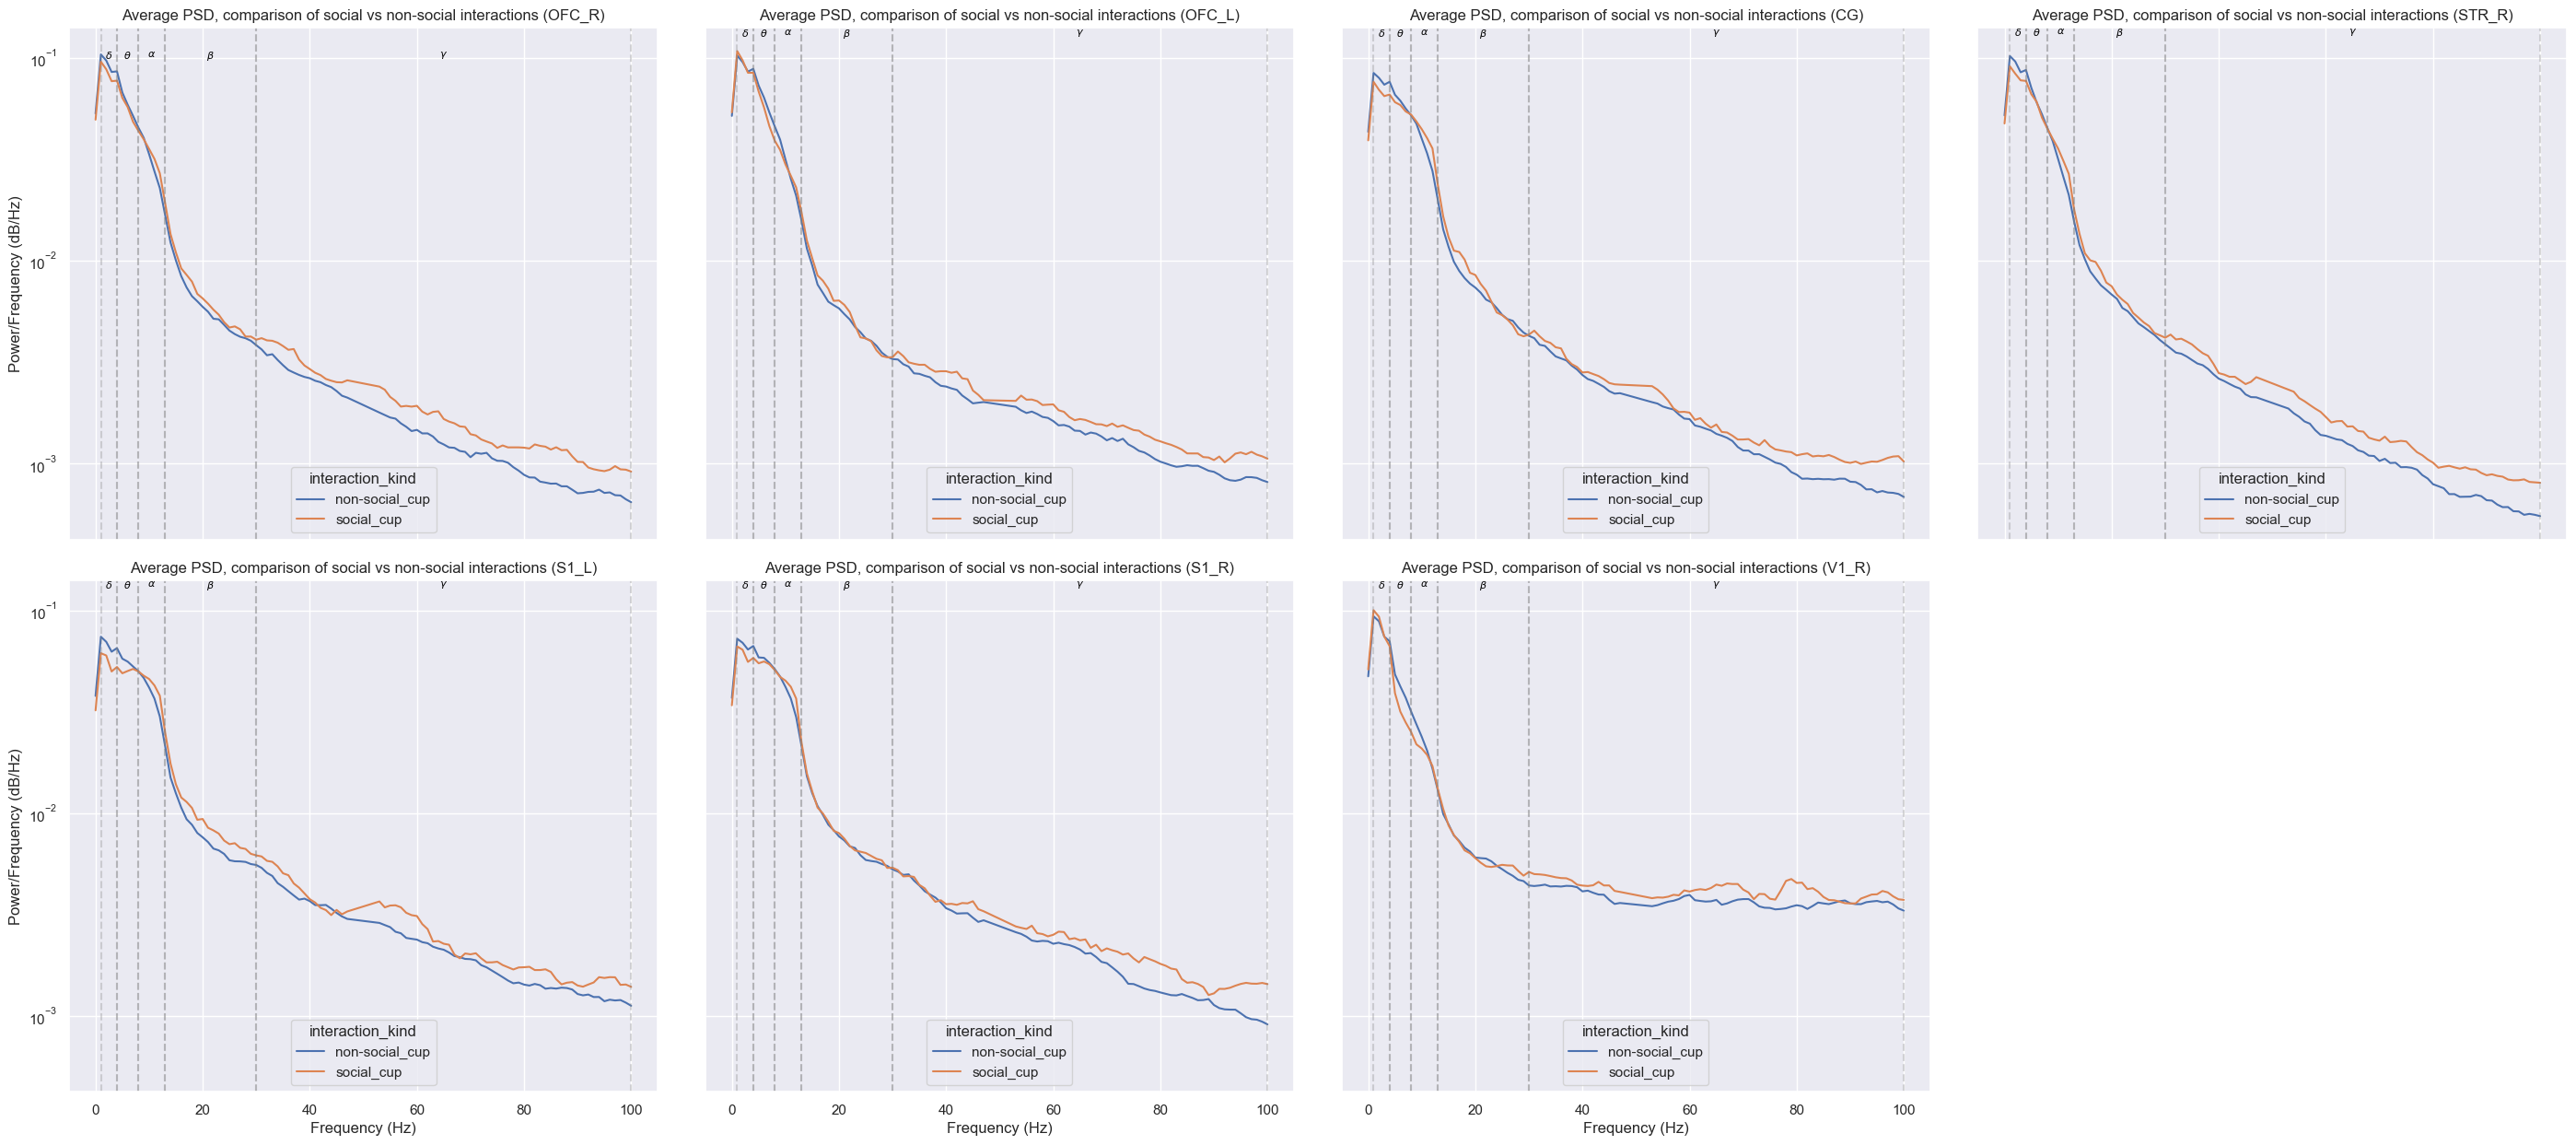

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="interaction_kind", legend=True, ax=axs[i], errorbar=('ci', 95))
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(f'Average PSD, comparison of social vs non-social interactions ({channel})')

plt.subplots_adjust(wspace=0.08, hspace=0.08)
axs[-1].remove()
plt.show()

## Analysis of all subjects

First we load all the epoch files


In [8]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

In [9]:
len(all_subject_epochs)

17

Let's calculate the PSDs again, but now for all animals

In [9]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]
    
    for interaction_type in subject_epochs.metadata.interaction_kind.unique():
        
        subject_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == interaction_type]
        
        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            decibels = nanpow2db(psds_sub)
            
            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]
        
            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)
            
            # normalize the raw psds
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "interaction_kind": interaction_type,
            })])
        
    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


Let's check if the dataframe contains what we think it does: all subjects, two types of interactions and the genotypes

In [10]:
print(f'Unique subjects: {df.subject_id.unique()} (n={len(df.subject_id.unique())})')
print(f'The genotypes: {np.unique([df[df.subject_id == subject_id].genotype.iloc[0] for subject_id in df.subject_id.unique()], return_counts=True)}')
print(f'Unique interactions: {df.interaction_kind.unique()}')

Unique subjects: ['80625' '81175' '39489' '79604' '81218' '78233' '81193' '78244' '79592'
 '78211' '78227' '81217' '81207' '80630' '80620' '39508' '79602'] (n=17)
The genotypes: (array(['DRD2-KO', 'DRD2-WT'], dtype='<U7'), array([9, 8]))
Unique interactions: ['social_cup' 'non-social_cup']


So there are 9 KOs and 8 WTs

First, let's make an overview grid plot of each subjects PSDs per channel


In [11]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average normalized raw power of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
axs[-1].remove()
plt.tight_layout()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/norm_powers_all_subjects.pdf'))

Also do this for decibels

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    sns.lineplot(channel_data, y='decibels (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)
    
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power in decibels (dB)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average normalized power (in decibels) of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/norm_powers_decibel_all_subjects.pdf'))

It seems like there's some kind of separation to be made in the powers when they're expressed in decibels. Let's get the subject ids of one of the groups.

In [13]:
channel_data = df[df.channel == "STR_R"]
freq100 = channel_data[channel_data.freq == 100.0]
freq100[freq100.decibels > -80.0].subject_id.unique()

array(['78233', '78244', '79592', '78211', '78227', '79602'], dtype=object)

These are all batch 1 and 2 animals, which is caused by their EEG being recorded at a way higher sampling frequency than the other subjects (19000 somthing Hz instead of 1084.something Hz)

We thus also need to normalize the decibel powers to make them comparable between subjects

81217 looks quite ugly, let's remove that one for now. 

We proceed with creating a grid plot that holds a subplot for each channel that displays the average power of the two different kinds of interactions

In [14]:
df = df[df.subject_id != '81217']
df.subject_id.unique()

array(['80625', '81175', '39489', '79604', '81218', '78233', '81193',
       '78244', '79592', '78211', '78227', '81207', '80630', '80620',
       '39508', '79602'], dtype=object)

Let's batch all social and non-social interaction epochs and show the average powers

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="interaction_kind", legend=True, ax=axs[i], errorbar=('ci', 95))
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average PSD of all social cup and non-social cup interaction epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/average_norm_interaction_powers.pdf'))

Let's also do this for the to decibel transformed PSD values

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='decibels', hue="interaction_kind", legend=True, ax=axs[i], errorbar=('ci', 95))
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Decibels (dB)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average power in decibels of all batched social cup and non-social cup interaction epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/average_norm_interaction_powers_decibels.pdf'))

### Are there power differences between the genotype in either interaction type?

Now plot the normalized PSDs per interaction type and hue also on genotype

In [17]:
for interaction_kind in df.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df[df.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power during {"social interaction" if interaction_kind == "social_cup" else "non-social interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_norm_genotype_powers_{interaction_kind}.pdf'))

Now, instead of batching all WT or KO epochs together and averaging the power, we will average the power of each subject, and then average the WT subjects their powers and the KO subjects their powers

In [18]:
for interaction_kind in df.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df[df.interaction_kind == interaction_kind]
    
    # get the subject's averages for every frequency of each channel 
    subject_averages = interaction_data.groupby(['subject_id', 'channel', 'freq']).agg({
        'psd': 'mean', 
        'psd (norm)': 'mean',
        'genotype': 'first'
    }).reset_index()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = subject_averages[subject_averages.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power during {"social interaction" if interaction_kind == "social_cup" else "non-social interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_subj_averages_norm_genotype_powers_{interaction_kind}.pdf'))

Let's again do the same for the power values that were converted to decibels (log scale already)

In [19]:
for interaction_kind in df.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df[df.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='decibels', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power in decibels (dB)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power (in decibels) during {"social interaction" if interaction_kind == "social_cup" else "non-social interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_subj_averages_norm_genotype_powers_decibel{interaction_kind}.pdf'))

There doesn't seem to be a difference in power when comparing social to non-social interactions for either genotype

Now, we calculate a ratio between the social-cup and non-social cup powers per subjects, and then take the average of those ratios per genotype.

Let's calculate the power ratios of social- over non-social cup interaction epochs as well as the decibel ratio equivalent.

In [21]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    if subject_epochs.metadata.subject_id.iloc[0] == '81217':
        print('Skipping 81217')
        continue
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]

    social_cup_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == "social_cup"]
    non_social_cup_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == "non-social_cup"]
    
    for channel in wanted_chans:

        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            social_cup_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_epochs.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        decibels = nanpow2db(psds_sub)
        
        mean_psd_sub_social = np.mean(psds_sub[:, 0, :], axis=0)
        mean_decibels_social = np.mean(decibels[:, 0, :], axis=0)
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            non_social_cup_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_epochs.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        decibels = nanpow2db(psds_sub)
        
        mean_psd_sub_non_social = np.mean(psds_sub[:, 0, :], axis=0)
        mean_decibels_non_social = np.mean(decibels[:, 0, :], axis=0)
       
        social_over_non_social_psd_ratio = mean_psd_sub_social / mean_psd_sub_non_social
        social_over_non_social_decibel_ratio = mean_decibels_social / mean_decibels_non_social

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd_ratio": social_over_non_social_psd_ratio,
            "decibel_ratio": social_over_non_social_decibel_ratio,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
        })])

    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 78211.
Done with subject 78227.
Skipping 81217
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


In [22]:
df

,freq,psd_ratio,decibel_ratio,subject_id,genotype,channel
0,0.0,1.228035,1.041453,80625,DRD2-KO,OFC_R
1,1.0,1.162498,1.044248,80625,DRD2-KO,OFC_R
2,2.0,1.092603,1.042860,80625,DRD2-KO,OFC_R
3,3.0,1.039685,1.042631,80625,DRD2-KO,OFC_R
4,4.0,0.997184,1.043595,80625,DRD2-KO,OFC_R
...,...,...,...,...,...,...
96,96.0,0.650973,1.017426,79602,DRD2-WT,V1_R
97,97.0,0.743184,1.015596,79602,DRD2-WT,V1_R
98,98.0,0.706956,1.015426,79602,DRD2-WT,V1_R
99,99.0,0.710097,1.013651,79602,DRD2-WT,V1_R


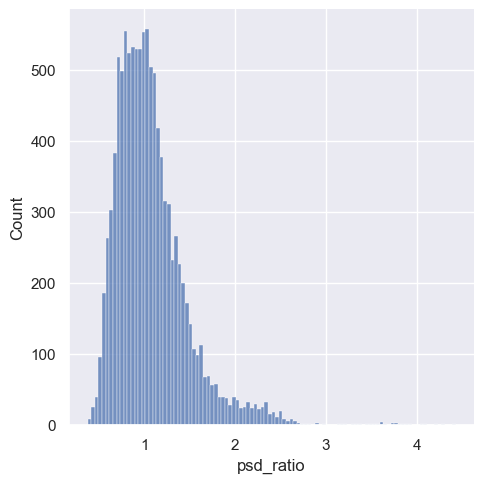

In [12]:
sns.displot(df.psd_ratio)
plt.show()

Remove outlier ratios based on IQR method

In [13]:
Q1 = np.percentile(df.psd_ratio, 25)
Q3 = np.percentile(df.psd_ratio, 75)

IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

df = df[(df['psd_ratio'] >= lower_bound) & (df['psd_ratio'] <= upper_bound)]

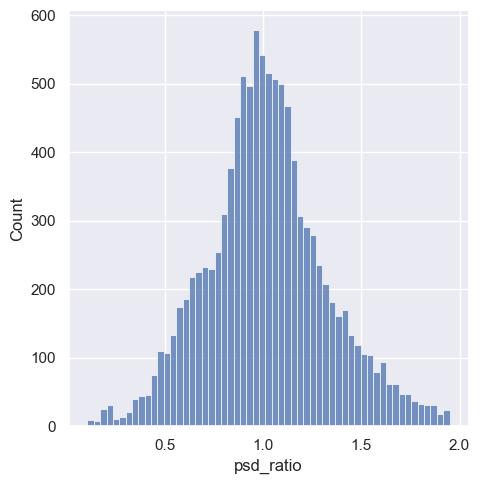

In [14]:
sns.displot(df.psd_ratio)
plt.show()

Now that the outliers are gone, we plot the averaged social cup over non-social cup power ratios of all subjects of the two genotypes.

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
    sns.lineplot(data=channel_data, x='freq', y='psd_ratio', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
    axs[i].axhline(y=1, linestyle='-', alpha=.5, color='gray')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power (µV²/Hz)')
    axs[i].set_title(f'{channel}')

plt.suptitle(
    "Social-cup over non-social-cup (absolute) power ratio, DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/norm_power_ratios_per_chan.pdf'))

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
    sns.lineplot(data=channel_data, x='freq', y='decibel_ratio', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1], band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
    axs[i].axhline(y=1, linestyle='-', alpha=.5, color='gray')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power in decibels (dB)')
    axs[i].set_title(f'{channel}')

plt.suptitle(
    "Social-cup over non-social-cup power ratio (in decibels), DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=0.95
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/norm_decibel_power_ratios_per_chan.pdf'))

In [25]:
df

,freq,psd_ratio,decibel_ratio,subject_id,genotype,channel
0,0.0,1.228035,1.041453,80625,DRD2-KO,OFC_R
1,1.0,1.162498,1.044248,80625,DRD2-KO,OFC_R
2,2.0,1.092603,1.042860,80625,DRD2-KO,OFC_R
3,3.0,1.039685,1.042631,80625,DRD2-KO,OFC_R
4,4.0,0.997184,1.043595,80625,DRD2-KO,OFC_R
...,...,...,...,...,...,...
96,96.0,0.650973,1.017426,79602,DRD2-WT,V1_R
97,97.0,0.743184,1.015596,79602,DRD2-WT,V1_R
98,98.0,0.706956,1.015426,79602,DRD2-WT,V1_R
99,99.0,0.710097,1.013651,79602,DRD2-WT,V1_R


Let's add the band name to each row

In [26]:
# let's add bad names to the df
for band, (start, end) in freq_bands_eeg.items():
    df.loc[(df['freq'] > start) & (df['freq'] <= end), 'band'] = band

In [27]:
df

,freq,psd_ratio,decibel_ratio,subject_id,genotype,channel,band
0,0.0,1.228035,1.041453,80625,DRD2-KO,OFC_R,NaN
1,1.0,1.162498,1.044248,80625,DRD2-KO,OFC_R,NaN
2,2.0,1.092603,1.042860,80625,DRD2-KO,OFC_R,$\delta$
3,3.0,1.039685,1.042631,80625,DRD2-KO,OFC_R,$\delta$
4,4.0,0.997184,1.043595,80625,DRD2-KO,OFC_R,$\delta$
...,...,...,...,...,...,...,...
96,96.0,0.650973,1.017426,79602,DRD2-WT,V1_R,$\gamma$
97,97.0,0.743184,1.015596,79602,DRD2-WT,V1_R,$\gamma$
98,98.0,0.706956,1.015426,79602,DRD2-WT,V1_R,$\gamma$
99,99.0,0.710097,1.013651,79602,DRD2-WT,V1_R,$\gamma$


Now we group the data of each subject and each band within the subject and average the psd_ratio per band

In [28]:
df_grouped = df.groupby(['subject_id', 'channel', 'band']).agg({'psd_ratio': 'mean', 'decibel_ratio': 'mean', 'genotype': 'first'}).reset_index()
df_grouped.head()

,subject_id,channel,band,psd_ratio,decibel_ratio,genotype
0,39489,CG,$\alpha$,0.678616,1.011249,DRD2-KO
1,39489,CG,$\beta$,0.793377,1.008929,DRD2-KO
2,39489,CG,$\delta$,0.559161,1.021990,DRD2-KO
3,39489,CG,$\gamma$,0.731285,1.009606,DRD2-KO
4,39489,CG,$\theta$,0.738144,1.016646,DRD2-KO


In [29]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharey=True, sharex=True)
axs = axs.ravel()

palette_dark = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}
palette_light = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}

for i, channel in enumerate(wanted_chans):
    
    df_grouped_chan = df_grouped[df_grouped.channel == channel]
    
    sns.boxplot(data=df_grouped_chan, x='band', y='psd_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], palette=palette_dark, showfliers=False, order=freq_bands_eeg.keys())
    
    sns.swarmplot(data=df_grouped_chan, x='band', y='psd_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], dodge=True, palette=palette_light, color="white", edgecolor="auto", s=6, legend=False, order=freq_bands_eeg.keys())
    
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    "Boxplot of social- over non-social cup power ratio per band, DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/boxplot_power_ratios_per_band.pdf'))

And the same for the decibels again

In [30]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True)
axs = axs.ravel()

palette_dark = {'DRD2-WT': '#6A8D73', 'DRD2-KO': '#984447'}
palette_light = {'DRD2-WT': '#AEC2B3', 'DRD2-KO': '#C68083'}

for i, channel in enumerate(wanted_chans):
    df_grouped_chan = df_grouped[df_grouped.channel == channel]

    sns.boxplot(data=df_grouped_chan, x='band', y='decibel_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], palette=palette_dark, showfliers=False, order=freq_bands_eeg.keys())

    sns.swarmplot(data=df_grouped_chan, x='band', y='decibel_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], dodge=True, palette=palette_light, color="white", edgecolor="auto", s=6, legend=False, order=freq_bands_eeg.keys())

    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    "Boxplot of social- over non-social cup power ratio (in decibels) per band, DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/boxplot_power_ratios_decibel_per_band.pdf'))

Let's perform some statistics on the psd_ratio to compare WT and KO

In [23]:
from scipy.stats import ttest_ind

df_grouped_wt = df_grouped[df_grouped.genotype == 'DRD2-WT']
df_grouped_ko = df_grouped[df_grouped.genotype == 'DRD2-KO']

for channel in wanted_chans:
    for band in freq_bands_eeg.keys():
        data_wt = df_grouped_wt[(df_grouped_wt.channel == channel) & (df_grouped_wt.band == band)]['psd_ratio']
        data_ko = df_grouped_ko[(df_grouped_ko.channel == channel) & (df_grouped_ko.band == band)]['psd_ratio']
        
        print(channel, band, ':', ttest_ind(data_wt, data_ko).pvalue)

OFC_R $\delta$ : 0.8455102470350181
OFC_R $\theta$ : 0.7260098562032092
OFC_R $\alpha$ : 0.4260678009100125
OFC_R $\beta$ : 0.13632342134309322
OFC_R $\gamma$ : 0.33529042399087694
OFC_L $\delta$ : 0.6277580650581
OFC_L $\theta$ : 0.7662698557101831
OFC_L $\alpha$ : 0.32643483887653957
OFC_L $\beta$ : 0.21883749180013967
OFC_L $\gamma$ : 0.44935068791938715
CG $\delta$ : 0.9741620534283342
CG $\theta$ : 0.5313995638659461
CG $\alpha$ : 0.3843700325612216
CG $\beta$ : 0.1144615213681868
CG $\gamma$ : 0.3329386793969653
STR_R $\delta$ : 0.8114606197190983
STR_R $\theta$ : 0.6020856444688955
STR_R $\alpha$ : 0.28992869441894153
STR_R $\beta$ : 0.170753216047439
STR_R $\gamma$ : 0.6775214500455109
S1_L $\delta$ : 0.775602459537976
S1_L $\theta$ : 0.7990604811894497
S1_L $\alpha$ : 0.30836213276868085
S1_L $\beta$ : 0.09598471602078308
S1_L $\gamma$ : 0.13593231745673287
S1_R $\delta$ : 0.8295050396274268
S1_R $\theta$ : 0.5093181214339936
S1_R $\alpha$ : 0.24495468341626606
S1_R $\beta$ : 

## Let's separate the batches on sampling frequency and batch all social epochs again

For this experiment, batches 1, 2, 3, and 4 were recorded at a sampling frequency of 19525 Hz. Batches 5, 5b and 6 were recorded at a sampling frequency of 1084.72 Hz.

In [10]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]
    
    for interaction_type in subject_epochs.metadata.interaction_kind.unique():
        
        subject_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == interaction_type]
        
        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            decibels = nanpow2db(psds_sub)
            
            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]
        
            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)
            
            # normalize the raw psds
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "interaction_kind": interaction_type,
            })])
        
    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


In [11]:
df.shape

(23230, 9)

In [12]:
ids_high_sf = [str(key) for key, value in subject_id_batch_cage_dict.items() if 'batch1' in value or 'batch2' in value]
print(ids_high_sf)

['78211', '79593', '78233', '79592', '78227', '79604', '78244', '79602']


In [13]:
df_high_sf = df[df.subject_id.isin(ids_high_sf)]
df_low_sf = df[~df.subject_id.isin(ids_high_sf)]

Let's inspect

In [14]:
df_high_sf.head()

,freq,psd,psd (norm),decibels,decibels (norm),subject_id,genotype,channel,interaction_kind
0,0.0,0.000001,0.045812,-64.691146,-0.008551,79604,DRD2-KO,OFC_R,non-social_cup
1,1.0,0.000002,0.085220,-61.922225,-0.008183,79604,DRD2-KO,OFC_R,non-social_cup
2,2.0,0.000002,0.078938,-62.125738,-0.008211,79604,DRD2-KO,OFC_R,non-social_cup
3,3.0,0.000002,0.070809,-62.464463,-0.008256,79604,DRD2-KO,OFC_R,non-social_cup
4,4.0,0.000002,0.072185,-62.262623,-0.008230,79604,DRD2-KO,OFC_R,non-social_cup


In [15]:
df_low_sf.head()

,freq,psd,psd (norm),decibels,decibels (norm),subject_id,genotype,channel,interaction_kind
0,0.0,0.000001,0.051193,-66.013034,-0.008247,80625,DRD2-KO,OFC_R,non-social_cup
1,1.0,0.000002,0.098988,-63.148220,-0.007887,80625,DRD2-KO,OFC_R,non-social_cup
2,2.0,0.000002,0.091629,-63.346837,-0.007911,80625,DRD2-KO,OFC_R,non-social_cup
3,3.0,0.000002,0.080499,-63.713355,-0.007957,80625,DRD2-KO,OFC_R,non-social_cup
4,4.0,0.000002,0.083020,-63.448039,-0.007924,80625,DRD2-KO,OFC_R,non-social_cup


### High sampling frequency batches

How many of each genotype in the high frequency batches?

In [21]:
np.unique(df_high_sf[(df_high_sf.freq == 1.0) & (df_high_sf.channel == 'OFC_R') & (df_high_sf.interaction_kind == 'social_cup')].genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([4, 3]))

So, there are 4 KOs and 3 WTs in the first 2 batches. Let's plot the difference in social epoch power between the two genotypes again.

In [22]:
for interaction_kind in df_high_sf.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df_high_sf[df_high_sf.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power of {interaction_kind} interactions - DRD2-WT versus DRD2-KO - High sampling frequency batches (n WT = 3, n KO = 4)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_{interaction_kind}_batches_1_and_2.pdf'))

There seems to be something going on here in the higher frequencies (beta and gamma).

### Low sampling frequency batches

Now, let's do the same for the low sampling frequency batches.

How many of each genotype in the lower frequency batches?

In [23]:
np.unique(df_low_sf[(df_low_sf.freq == 1.0) & (df_low_sf.channel == 'STR_R') & (df_low_sf.interaction_kind == 'non-social_cup')].genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([5, 5]))

In [24]:
for interaction_kind in df_high_sf.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df_low_sf[df_low_sf.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power of {interaction_kind} interactions - DRD2-WT versus DRD2-KO - High sampling frequency batches (n WT = 5, n KO = 5)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_{interaction_kind}_batches_4-6.pdf'))